In [1]:
from data_processing import Dataset
from noise import NoiseScheduler
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torchvision import transforms
import torch
import random

seed = 10
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [2]:
if(torch.backends.cuda.is_built()) : 
    device='cuda'
elif(torch.backends.mps.is_built()) : 
    device='mps'
else : 
    device='cpu'

In [3]:
data_dir = "Datasets"       # Change directory where data is stored here

start_idx = 12000 # Adjust which events to look at from the dataset, make different to the training data 
end_idx = 12300
dataset = Dataset(10000, (120, 72), signal_file=f"{data_dir}/CaloImages_signal.root", pile_up_file=f"{data_dir}/CaloImages_bkg.root", save=False, start_idx=start_idx, end_idx=end_idx) # 120 eta, 72 phi

In [4]:
dataset() #once this is cached, you don't have to re-load

INFO:root:loading file Datasets/CaloImages_signal.root
loading file Datasets/CaloImages_signal.root
100%|██████████| 300/300 [00:00<00:00, 911.85it/s]


Show original shape of image to determine which axis corresponds to eta and phi:

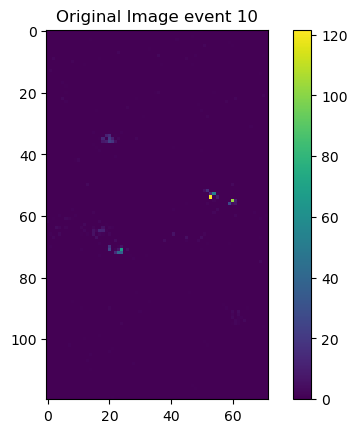

In [5]:

# Select an index for the image you want to visualize
i = 10  # Change this to visualize a different image

# Access the original image from the dataset
original_image = dataset.signal[i]

# Display the original image using matplotlib
plt.imshow(original_image)
plt.colorbar()
plt.title(f"Original Image event {i}")
plt.show()


In [6]:
new_dim=(64,64)

In [7]:
saturation_value = 512 # Change saturation value here (make same as training value)
dataset.preprocess(saturation_value, new_dim)     # ensure these have the same values as when the model was trained

INFO:root:re-sizing
re-sizing


In [8]:
preprocess = transforms.Compose(
        [
            transforms.ToTensor()
        ]
)

MOVING DATA TO GPU

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
# Extract horizontal strip from y=26 to y=38 (12 pixels tall)
# Change how much of image to train model on here
strip_size = 'strip'

# Change size of strip here
strip_top = 26
strip_bottom = 38

MSE_y_start = strip_top
MSE_y_end = strip_bottom

if strip_size == 'strip':
    y_start = strip_top
    y_end = strip_bottom
    
elif strip_size == 'full_image':
    y_start = 0
    y_end = 64




In [11]:
# Added .to(device) to move data to GPU
clean_frames = preprocess(dataset.signal).float().permute(1, 2, 0).unsqueeze(1)[:, :, y_start:y_end, :].to(device) #pytorch symantics
pile_up = preprocess(dataset.pile_up).float().permute(1, 2, 0).unsqueeze(1)[:, :, y_start:y_end, :].to(device)

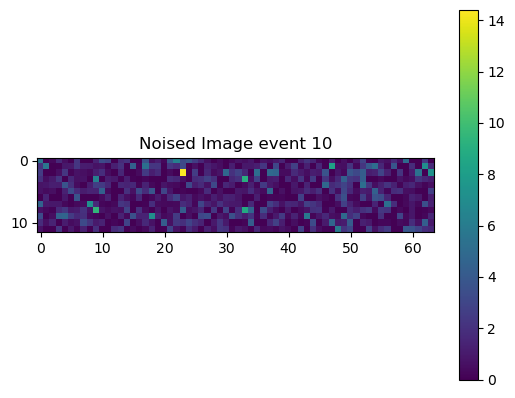

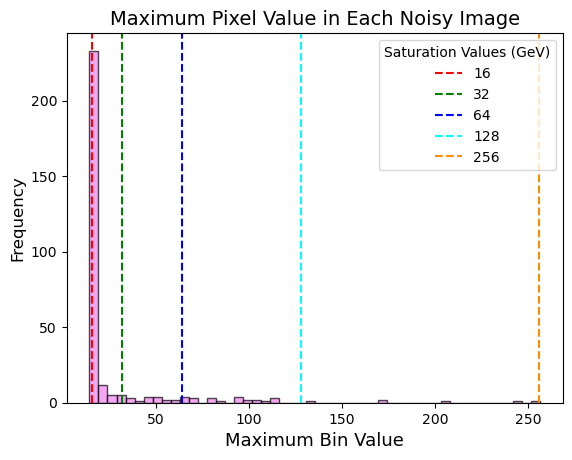

Threshold (GeV)      Perc of Events Above Threshold(%)
16                   25.00                    
32                   16.00                    
64                   9.00                     
128                  2.00                     
256                  0.33                     
512                  0.00                     


In [12]:
### Select one image to perform inference on
noise_scheduler = NoiseScheduler('pile-up')

# Each unit of timestep represents an addtional 5 pile-up events (max 40 = 200PU)
timestep = torch.LongTensor([40]).to(device)   # Added .to(device) to move data to GPU
random_seed = 42


# Aside: calculate the maximum pixel value in each event loaded in the Dataset
noisy_max_bin = np.zeros(end_idx-start_idx)
for event in range(end_idx-start_idx):
    noisy_images, noise = noise_scheduler.add_noise(clean_frame=clean_frames[event], noise_sample=pile_up, timestep=timestep, random_seed=random_seed, n_events = end_idx-start_idx)
    noisy_max_bin[event] = noisy_images.max().item()

    if event == i:
        plt.imshow(noisy_images[0].cpu())
        plt.colorbar()
        plt.title(f"Noised Image event {event}")
        plt.show()

# Plot histogram to see distribution of maximum pixel value in each event
plt.hist(noisy_max_bin, bins=50, color='violet', alpha=0.7, edgecolor='black')
plt.title('Maximum Pixel Value in Each Noisy Image', fontsize=14)
plt.xlabel('Maximum Bin Value', fontsize=13)
plt.ylabel('Frequency', fontsize=12)
# Plot vertical lines at x values of 16, 32, 64
plt.axvline(x=16, color='r', linestyle='--', label='16')
plt.axvline(x=32, color='green', linestyle='--', label='32')
plt.axvline(x=64, color='blue', linestyle='--', label='64')
plt.axvline(x=128, color='cyan', linestyle='--', label='128')
plt.axvline(x=256, color='darkorange', linestyle='--', label='256')

# Add legend
plt.legend(title='Saturation Values (GeV)')
plt.show()

# Calculate the percentage of events with maximum pixel value greater than given thresholds
thresholds = [16, 32, 64, 128, 256, 512]
percentages = [(noisy_max_bin > threshold).sum() / len(noisy_max_bin) * 100 for threshold in thresholds]

# Print the table
print(f"{'Threshold (GeV)':<20} {'Perc of Events Above Threshold(%)':<25}")
for threshold, percentage in zip(thresholds, percentages):
    print(f"{threshold:<20} {percentage:<25.2f}")

In [13]:
noisy_image, noise = noise_scheduler.add_noise(clean_frame=clean_frames[i], noise_sample=pile_up, timestep=timestep, random_seed=random_seed, n_events = end_idx-start_idx)
# Apply saturation value clipping and scaling
noisy_image = torch.clamp(noisy_image, max=saturation_value)

Text(0.5, 1.0, 'Noised Image event 10')

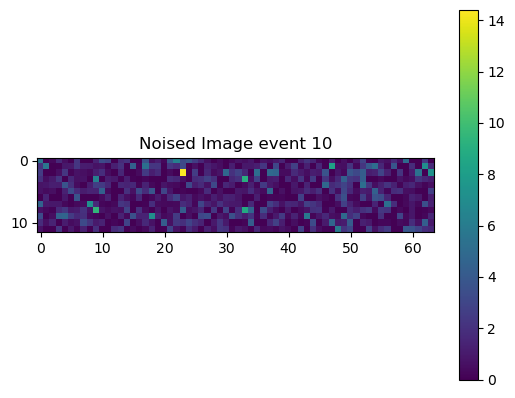

In [14]:
plt.imshow(noisy_image.cpu().numpy()[0])
plt.colorbar()
plt.title(f"Noised Image event {i}")

In [15]:
from models_stripped_kernels import Model, UNetLite_hls # Make sure to import same model as training

modtype = 'UNet_lite' # Change Model type here

if modtype == 'UNet2d':
    model = Model('UNet', new_dim)
    model = model.__getitem__()

elif modtype == 'UNet_lite':
    model = UNetLite_hls()

# Move model to GPU
model = model.to(device)    

print(model)

c:\Users\Luke Johnson\Anaconda3\envs\sd_env\lib\site-packages\diffusers\models\transformers\transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


UNetLite_hls(
  (relu): ReLU()
  (pool): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (up): ConvTranspose2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
  (emb1): Linear(in_features=4, out_features=1, bias=True)
  (convd1_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (normd1_1): GroupNorm(8, 16, eps=1e-05, affine=True)
  (convd1_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (normd1_2): GroupNorm(8, 16, eps=1e-05, affine=True)
  (emb2): Linear(in_features=4, out_features=16, bias=True)
  (convd2_1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (normd2_1): GroupNorm(8, 16, eps=1e-05, affine=True)
  (convd2_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (normd2_2): GroupNorm(8, 16, eps=1e-05, affine=True)
  (emb4): Linear(in_features=4, out_features=16, bias=True)
  (convb1_1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (normb1_1): GroupNorm(8, 16, eps=1e-05, affine=Tru

In [16]:
if modtype == 'UNet2d':
    # Use 1st line for huggingface trained model
    # Use 2nd line for retrained model

    #trained_model_path = '/cephfs/dice/projects/L1T/diffusion/trained_models/trained_diffusor.pt'
    trained_model_path = 'retrained_models_UNet2d/temp/model_epoch_9.pt'

elif modtype == 'UNet_lite': 
    trained_model_path = 'trained_models_lite/saturation=512_strip/model_epoch_9.pt' # Specify folder for which trained model here!

print(trained_model_path)

trained_models_lite/saturation=512_strip/model_epoch_9.pt


In [17]:
checkpoint = torch.load(trained_model_path, map_location=device)  # Ensure checkpoint is loaded to the correct device

In [18]:
model.load_state_dict(checkpoint)

<All keys matched successfully>

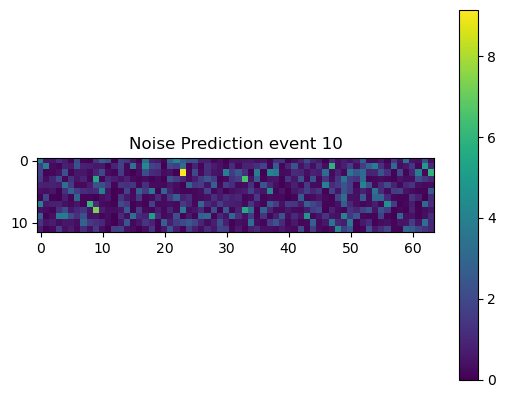

In [19]:
if modtype == 'UNet2d':
    noise_pred = model(noisy_image.unsqueeze(1), timestep, return_dict=False)[0][0]
elif modtype == 'UNet_lite':
    noise_pred = model(noisy_image.unsqueeze(1), timestep)[0]

# Display the noise prediction
ims = plt.imshow(noise_pred[0].detach().cpu().numpy()) # Move prediction back to CPU for visualization
plt.colorbar(ims)
plt.title(f"Noise Prediction event {i}")
plt.show()

In [20]:
de_noised = F.relu(noisy_image[0].cpu() - (noise_pred[0].detach().cpu().numpy()))

Text(0.5, 1.0, 'Denoised Image event 10')

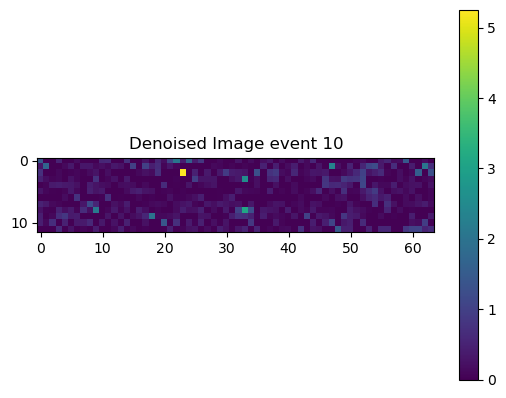

In [21]:
im = plt.imshow(de_noised)
plt.colorbar(im)
plt.title(f"Denoised Image event {i}")

Text(0.5, 1.0, 'Clean Image event 10')

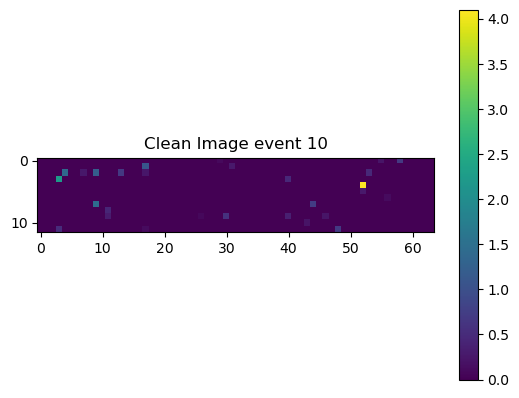

In [22]:
im2 = plt.imshow(clean_frames.cpu()[i].squeeze())
plt.colorbar(im2)
plt.title(f"Clean Image event {i}")

In [23]:
err = clean_frames[i].cpu().squeeze()-de_noised
print(f"MSE for event {i}: {np.mean((err.numpy())**2)}")


MSE for event 10: 0.22490637004375458


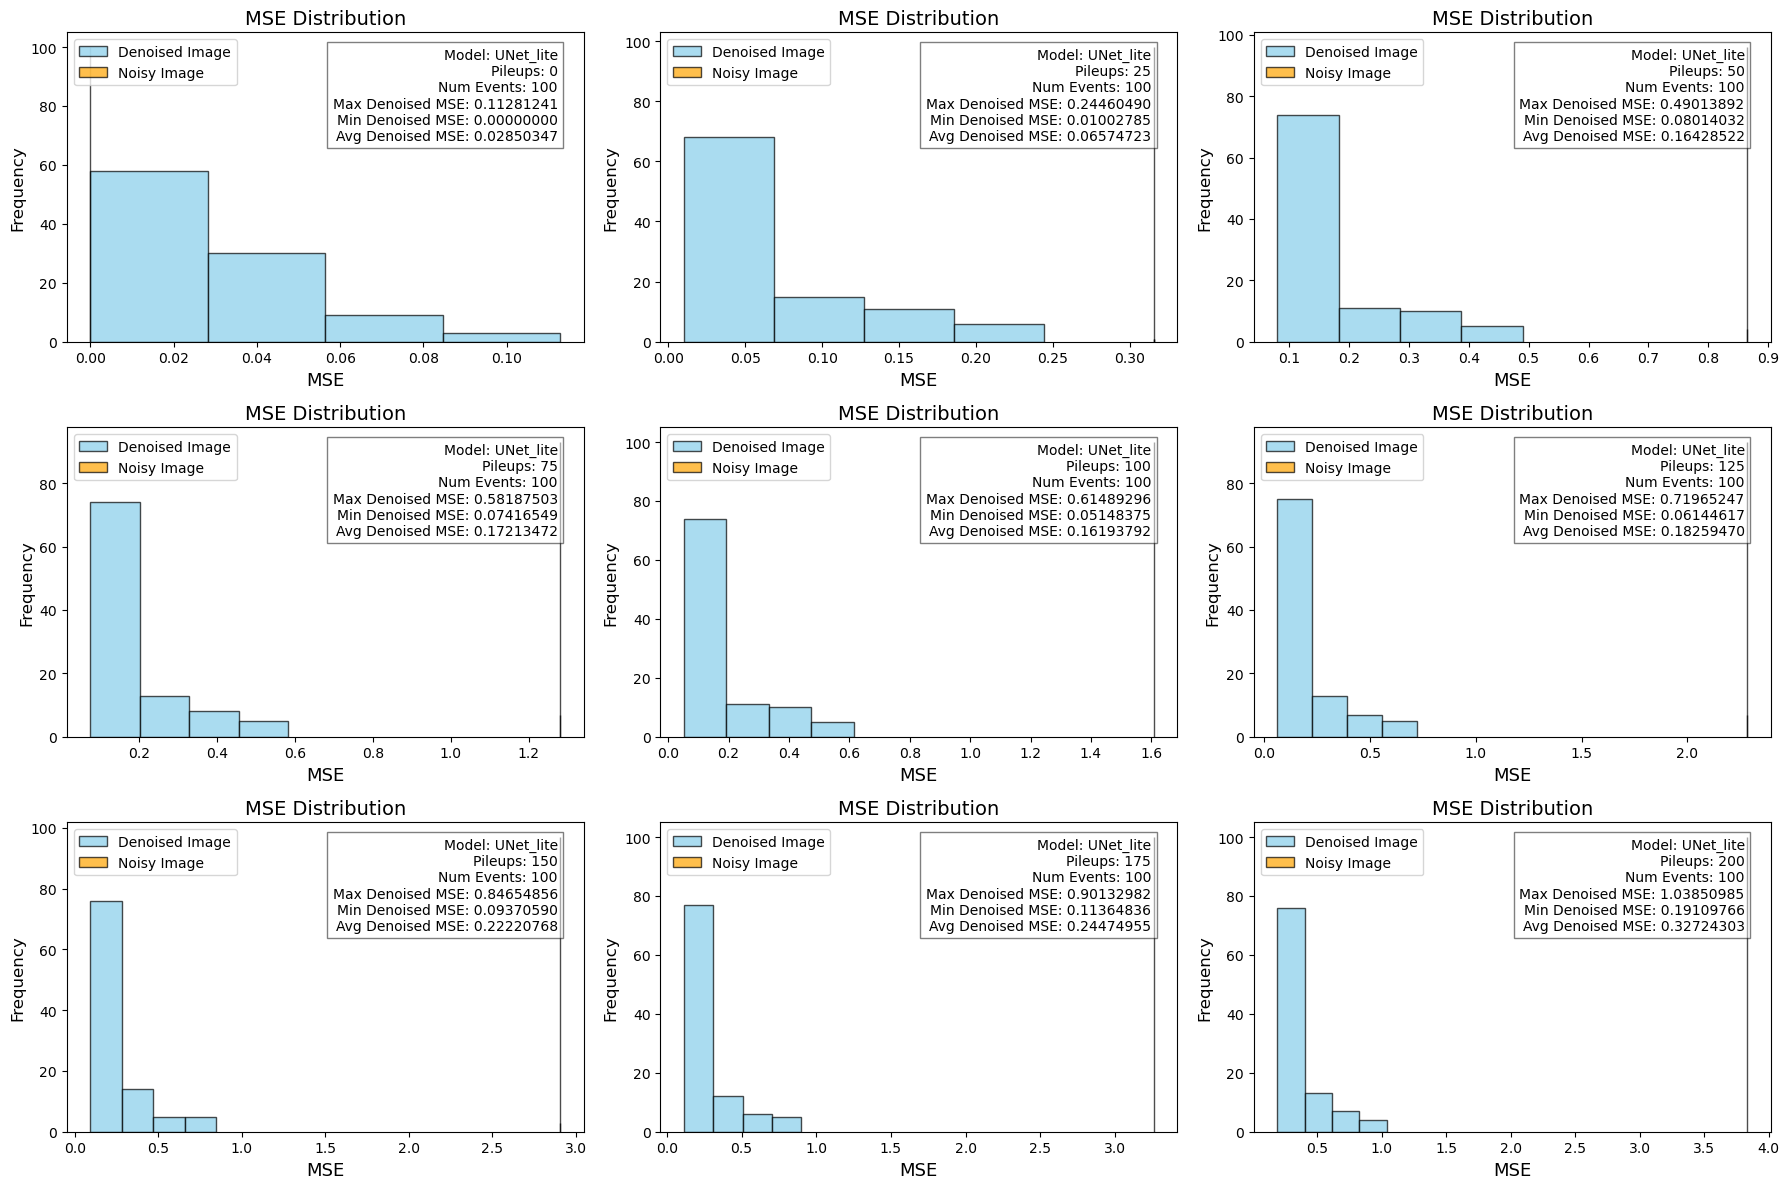

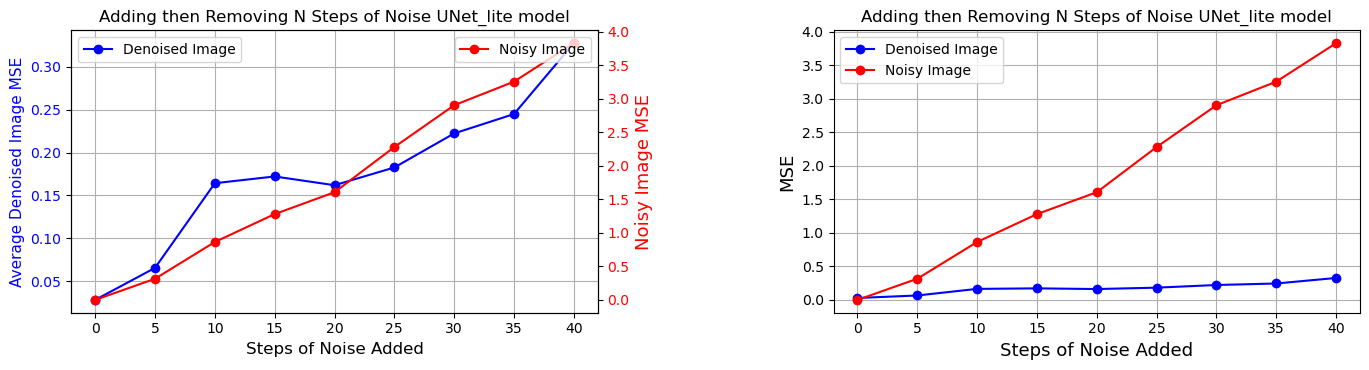

In [24]:
timesteps = [0, 5, 10, 15, 20, 25, 30, 35, 40] # Which timesteps to perform denoising at
num_events = 100 # Number of trials where denoising process is performed and evaluated
# Create arrays to hold MSEs for each event at each timestep
denoised_results = np.zeros((len(timesteps),num_events)) # For MSEs between denoised image and clean image
noisy_results = np.zeros((len(timesteps),num_events)) # For MSEs between noisy image and clean image

if len(timesteps)%3 != 0: #Add extra row if number not divisible by 3 to hold the remaining plots
    extra_row=1
else:
    extra_row=0
    

fig, axes = plt.subplots(len(timesteps)//3 + extra_row, 3, figsize=(18, 12))  # eg. 3x3 grid for 9 timesteps

#Add a specific amount of noise at each timestep
for idx, timestep_value in enumerate(timesteps): # pairs up values of timesteps (=timestep_value) with their indexes(=idx)

    # Run the denoising process a number of  times
    for event in range(num_events):
        noise_scheduler = NoiseScheduler('pile-up')
        timestep = torch.LongTensor([timestep_value])
        timestep = timestep.to(device)
        random_seed = 42

        # Create noisy image and noise prediction
        noisy_image, noise = noise_scheduler.add_noise(clean_frame=clean_frames[event], noise_sample=pile_up, timestep=timestep, random_seed=random_seed, n_events=end_idx-start_idx)
        
        # Apply saturation value clipping and scaling
        noisy_image = torch.clamp(noisy_image, max=saturation_value)
        
        if modtype == 'UNet2d':
            noise_pred = model(noisy_image.unsqueeze(1), timestep, return_dict=False)[0][0]
        elif modtype == 'UNet_lite':
            noise_pred = model(noisy_image.unsqueeze(1), timestep)[0]

        de_noised = F.relu(noisy_image[0].cpu() - (noise_pred[0].detach().cpu().numpy()))
        # Calc difference between denoised image and clean image
        denoised_err = clean_frames[event].squeeze().cpu() - de_noised.cpu()
        denoised_MSE = np.mean((denoised_err.cpu().numpy())**2)
        denoised_results[idx, event] = denoised_MSE

        # Calc difference between noisy image and clean image
        noisy_err = clean_frames[event].squeeze() - noisy_image[0]
        noisy_MSE = np.mean((noisy_err.cpu().numpy())**2)
        noisy_results[idx, event] = noisy_MSE
    
    av_denoised_MSE = np.mean(denoised_results, axis=1)
    av_noisy_MSE = np.mean(noisy_results, axis=1)
    
    # Plot required number of histograms
    ax = axes[idx // 3, idx % 3]  # Determine subplot position

    # Plot histogram for denoised results at each timestep
    denoised_mses_bins = np.linspace(min(denoised_results[idx]), max(denoised_results[idx]), 5)
    ax.hist(denoised_results[idx], bins=denoised_mses_bins, color='skyblue', alpha=0.7, edgecolor='black', label='Denoised Image')

    # Plot histogram for noisy results at each timestep on same plot
    noisy_mses_bins = np.linspace(min(noisy_results[idx]), max(noisy_results[idx]), 11)
    ax.hist(noisy_results[idx], bins=noisy_mses_bins, color='orange', alpha=0.7, edgecolor='black', label='Noisy Image')
    ax.set_title('MSE Distribution', fontsize=14)
    ax.set_xlabel('MSE', fontsize=13)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.legend(loc='upper left')
    
    # Adding text box with statistics
    textstr = '\n'.join((
        f'Model: {modtype}',
        f'Pileups: {timestep_value*5}',
        f'Num Events: {num_events}',
        f'Max Denoised MSE: {max(denoised_results[idx]):.8f}',
        f'Min Denoised MSE: {min(denoised_results[idx]):.8f}',
        f'Avg Denoised MSE: {av_denoised_MSE[idx]:.8f}'
    ))
    ax.text(0.95, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0.5))

fig.tight_layout()
plt.show()

# Calculate and plot average MSE vs. level of noise added
fig, axs = plt.subplots(1, 2, figsize=(16,6))

# Plot both on same graph with different axes
axs[0].plot(timesteps, av_denoised_MSE, marker='o', linestyle='-', color='blue', label='Denoised Image')
axs[0].set_title(f'Adding then Removing N Steps of Noise {modtype} model', fontsize=12)
axs[0].set_xlabel('Steps of Noise Added', fontsize=12)
axs[0].set_ylabel('Average Denoised Image MSE', color='blue', fontsize=11)
axs[0].tick_params(axis='y', labelcolor='blue')
axs[0].grid(True)
axs[0].legend(loc='upper left')

axs[0] = axs[0].twinx()
axs[0].plot(timesteps, av_noisy_MSE, marker='o', linestyle='-', color='red', label='Noisy Image')
axs[0].set_ylabel('Noisy Image MSE', color='red', fontsize=13)
axs[0].tick_params(axis='y', labelcolor='red')
axs[0].legend(loc='upper right')

# Plot both on same graph with same axis
axs[1].plot(timesteps, av_denoised_MSE, marker='o', linestyle='-', color='blue', label='Denoised Image')
axs[1].plot(timesteps, av_noisy_MSE, marker='o', linestyle='-', color='red', label='Noisy Image')
axs[1].set_title(f'Adding then Removing N Steps of Noise {modtype} model', fontsize=12)
axs[1].set_xlabel('Steps of Noise Added', fontsize=13)
axs[1].set_ylabel('MSE', fontsize=13)
axs[1].legend()
axs[1].grid(True)


fig.tight_layout(pad=9)  # Adjust subplots to fit into figure area.

c:\Users\Luke Johnson\Anaconda3\envs\sd_env\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Luke Johnson\Anaconda3\envs\sd_env\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


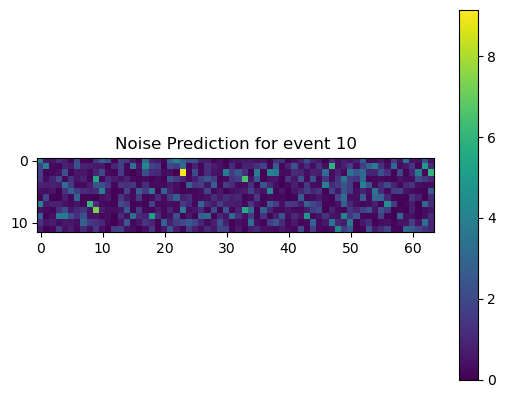

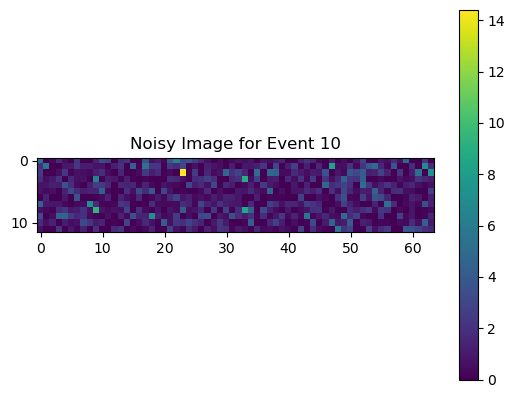

The maximum pixel value in the noisy image for Event 10 is: 14.40264892578125


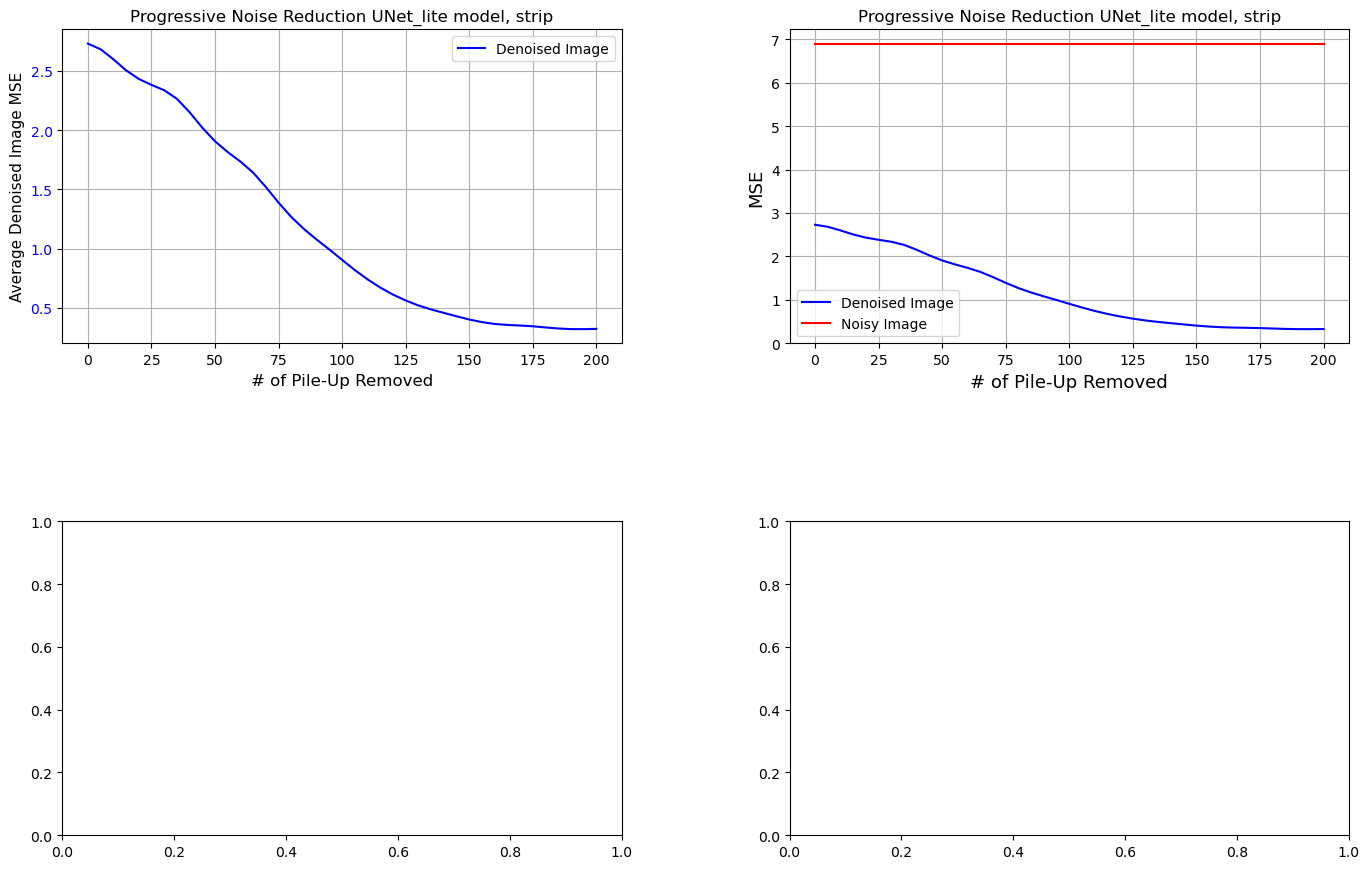

The avg MSE for the strip across 300 events is: 0.32372478723526
0.0000 % of events reached the saturation energy of 512 GeV


In [25]:
timesteps = np.arange(0,41,1) # Which timesteps to perform denoising at
num_events = end_idx - start_idx # Number of trials
 
# Create arrays to hold MSEs for each event at each timestep
denoised_results = np.zeros((len(timesteps),num_events)) # For MSEs between denoised image and clean image
denoised_results_strip = np.zeros((len(timesteps),num_events))
noisy_results = np.zeros(num_events) # For MSEs between noisy image and clean image
noisy_results_strip = np.zeros(num_events)
noisy_max_bin = np.zeros(num_events)

noise_scheduler = NoiseScheduler('pile-up')
maxTimestep = torch.LongTensor([40])

for event in range(num_events):
    random_seed = 42

    # Generate the noisy image at maxTimestep (200 pile-ups)
    noisy_image, noise = noise_scheduler.add_noise(clean_frame=clean_frames[event], noise_sample=pile_up, timestep=maxTimestep, random_seed=random_seed, n_events=end_idx-start_idx)

    # Apply saturation value clipping and scaling
    noisy_image = torch.clamp(noisy_image, max=saturation_value)
    
    noisy_err = clean_frames[0].squeeze() - noisy_image[0]
    noisy_MSE = np.mean((noisy_err.cpu().numpy())**2)
    noisy_results[event] = noisy_MSE
    noisy_max_bin[event] = noisy_image.max().item()
   
    noisy_MSE_strip = np.mean((noisy_err[MSE_y_start:MSE_y_end,:].cpu().numpy())**2)
    noisy_results_strip[event] = noisy_MSE_strip

    for idx, timestep_value in enumerate(timesteps): # pairs up values of timesteps (=timestep_value) with their indexes(=idx)

        timestep = torch.LongTensor([timestep_value])
        timestep = timestep.to(device)

        if modtype == 'UNet2d':
            noise_pred = model(noisy_image.unsqueeze(1), timestep, return_dict=False)[0][0]
        elif modtype == 'UNet_lite':
            noise_pred = model(noisy_image.unsqueeze(1), timestep)[0]

        if timestep_value in [40] and event == 10: # Look at how much pileup removal in the timestep value
           
            ims = plt.imshow(noise_pred[0].detach().cpu().numpy()) # Move prediction back to CPU for visualization
            plt.colorbar(ims)
            plt.title(f"Noise Prediction for event {event}")
            plt.show()

            ims2 = plt.imshow(noisy_image[0].detach().cpu().numpy())
            plt.colorbar(ims2)
            plt.title(f"Noisy Image for Event {event}")
            plt.show()

            # Print the maximum pixel value across the entire noisy image
            max_pixel_value = noisy_image.max().item()
            print(f"The maximum pixel value in the noisy image for Event {event} is: {max_pixel_value}")
        
        de_noised = F.relu(noisy_image[0].cpu() - (noise_pred[0].detach().cpu().numpy()))
        denoised_err = clean_frames[event].squeeze().cpu() - de_noised.cpu()
        denoised_MSE = np.mean((denoised_err.cpu().numpy())**2)
        denoised_results[idx, event] = denoised_MSE
        
        denoised_MSE_strip = np.mean((denoised_err[MSE_y_start:MSE_y_end,:].cpu().numpy())**2)
        denoised_results_strip[idx, event] = denoised_MSE_strip

av_denoised_MSE = np.mean(denoised_results, axis=1)
av_noisy_MSE = np.mean(noisy_results)

av_denoised_MSE_strip = np.mean(denoised_results_strip, axis=1)
av_noisy_MSE_strip = np.mean(noisy_results_strip)

# Calculate and plot average MSE vs. timestep
fig, axs = plt.subplots(2, 2, figsize=(16,11))

axs[0,0].plot(timesteps*5, av_denoised_MSE, linestyle='-', color='blue', label='Denoised Image')
axs[0,0].set_title(f'Progressive Noise Reduction {modtype} model, {strip_size}', fontsize=12)
axs[0,0].set_xlabel('# of Pile-Up Removed', fontsize=12)
axs[0,0].set_ylabel('Average Denoised Image MSE', fontsize=11)
axs[0,0].tick_params(axis='y', labelcolor='blue')
axs[0,0].grid(True)
axs[0,0].legend(loc='upper right')

axs[0,1].plot(timesteps*5, av_denoised_MSE, linestyle='-', color='blue', label='Denoised Image')
axs[0,1].plot(timesteps*5, [av_noisy_MSE]*len(timesteps), linestyle='-', color='red', label='Noisy Image')
axs[0,1].set_title(f'Progressive Noise Reduction {modtype} model, {strip_size}', fontsize=12)
axs[0,1].set_xlabel('# of Pile-Up Removed', fontsize=13)
axs[0,1].set_ylabel('MSE', fontsize=13)
axs[0,1].legend()
axs[0,1].grid(True)

if strip_size == 'full_image':
    axs[1,0].plot(timesteps*5, av_denoised_MSE_strip, linestyle='-', color='blue', label='Denoised Image')
    axs[1,0].set_title(f'Progressive Noise Reduction {modtype} model, Strip', fontsize=12)
    axs[1,0].set_xlabel('# of Pile-Up Removed', fontsize=12)
    axs[1,0].set_ylabel('Average Denoised Image MSE', fontsize=11)
    axs[1,0].tick_params(axis='y', labelcolor='blue')
    axs[1,0].grid(True)
    axs[1,0].legend(loc='upper right')

    axs[1,1].plot(timesteps*5, av_denoised_MSE_strip, linestyle='-', color='blue', label='Denoised Image')
    axs[1,1].plot(timesteps*5, [av_noisy_MSE_strip]*len(timesteps), linestyle='-', color='red', label='Noisy Image')
    axs[1,1].set_title(f'Progressive Noise Reduction {modtype} model, Strip', fontsize=12)
    axs[1,1].set_xlabel('# of Pile-Up Removed', fontsize=13)
    axs[1,1].set_ylabel('MSE', fontsize=13)
    axs[1,1].legend()
    axs[1,1].grid(True)
    print(f'The avg MSE for the strip (y={MSE_y_start} -> y={MSE_y_end}) across {num_events} events is:', av_denoised_MSE_strip[-1])

fig.tight_layout(pad=9)  # Adjust subplots to fit into figure area.
plt.show()

print(f'The avg MSE for the {strip_size} across {num_events} events is:', av_denoised_MSE[-1])

print(f'{(np.sum(noisy_max_bin == saturation_value)/noisy_max_bin.size)*100:.4f} % of events reached the saturation energy of {saturation_value} GeV')